In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
tqdm.pandas()

/tmp/ipykernel_849680/2505226845.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
# Function to load data
def _load_data(data_file):
    data = pd.read_csv(data_file)
    data['timestamp'] = pd.to_datetime(data['timestamp']) # convert to datetime
    data = data.sort_values(by='timestamp')
    data = data.set_index('timestamp')
    data = data.dropna(subset=['value']) # drop rows with missing values
    return data

# Function to find the 'value' an specified time offset later within a tolerance
def find_value_within_tolerance(df, current_time, offset=pd.DateOffset(hours=1), tolerance=pd.Timedelta(minutes=5)):
    desired_time = current_time + offset
    mask = (df.index >= desired_time - tolerance) & (df.index <= desired_time + tolerance)
    masked_df = df[mask]
    # if there are multiple rows within the tolerance, return the 'value' of the first one
    if len(masked_df) > 0:
        return masked_df.iloc[0]['value']
    else:
        return np.nan

# List of time offsets
time_offsets = [pd.DateOffset(hours=x) for x in [1, 2, 3, 4, 8, 12, 24, 48, 72, 96]] + [pd.DateOffset(days=x) for x in [5, 10]]

# List of column labels for the time-offset
column_labels = [f'value_{x}hr_later' for x in [1, 2, 3, 4, 8, 12, 24, 48, 72, 96]] + [f'value_{x}d_later' for x in [5,10]]


In [9]:
data_files = [
    '../../../data/Streamflow/fpe_stations/Avery Brook_Bridge_01171000/FLOW_CFS/images.csv',
    '../../../data/Streamflow/fpe_stations/Sanderson Brook_01171010/FLOW_CFS/images.csv',
    '../../../data/Streamflow/fpe_stations/West Branch Swift River_01174565/FLOW_CFS/images.csv',
    '../../../data/Streamflow/fpe_stations/West Brook Lower_01171090/FLOW_CFS/images.csv',
    '../../../data/Streamflow/fpe_stations/West Whately_01171005/FLOW_CFS/images.csv',
]


In [34]:
# Initialize an empty dictionary to store the correlation values
correlation_values = {}

# Try to load the correlation values from a file
try:
    with open('correlation_values.pkl', 'rb') as f:
        correlation_values = pickle.load(f)
        print('Loaded correlation values from file')
except:
    pass

# Iterate over the data files
for data_file in data_files:
    print(f'Processing {data_file}')
    if data_file not in correlation_values:
        print(f'{data_file} not in correlation_values')
        correlation_values[data_file] = {}
    data = _load_data(data_file)

    for offset, label in zip(time_offsets, column_labels):
        tick_label = label.split('_')[-2]
        
        # Check if the correlations for this time offset have already been computed
        if tick_label in correlation_values[data_file]:
            print(f'Correlation {tick_label}: {correlation_values[data_file][tick_label]}')
            continue
        # Add columns with the value at each time offset later using the function
        tqdm.pandas(desc=label)
        data[label] = data.progress_apply(lambda row: find_value_within_tolerance(data, row.name, offset=offset), axis=1)
    
        # Compute and store the correlation for each time offset
        correlation_values[data_file][tick_label] = data['value'].corr(data[label])

        # Print the correlation values
        for time_offset, correlation in correlation_values[data_file].items():
            print(f'Correlation {time_offset}: {correlation}')

Loaded correlation values from file
Processing ../../../data/Streamflow/fpe_stations/Avery Brook_Bridge_01171000/FLOW_CFS/images.csv
Correlation 1hr: 0.9269792395904907
Correlation 2hr: 0.8375921484983222
Correlation 3hr: 0.7644320431979471
Correlation 4hr: 0.6989510851924505
Correlation 8hr: 0.4458019049479716
Correlation 12hr: 0.33813166672242645
Correlation 24hr: 0.23078332322785491
Correlation 48hr: 0.17095004623710086
Correlation 72hr: 0.14733598949757137
Correlation 96hr: 0.1364913074187413
Correlation 5d: 0.15521757312477213
Correlation 10d: 0.09861836188294976
Processing ../../../data/Streamflow/fpe_stations/Sanderson Brook_01171010/FLOW_CFS/images.csv
Correlation 1hr: 0.9680090441886697
Correlation 2hr: 0.9087652208507772
Correlation 3hr: 0.8441914261641634
Correlation 4hr: 0.7910230283242471
Correlation 8hr: 0.6070637815773123
Correlation 12hr: 0.49575336881534776
Correlation 24hr: 0.37524808951385236
Correlation 48hr: 0.27620859606362436
Correlation 72hr: 0.243200953472244
C

In [21]:
# with open('correlation_values.pkl', 'wb') as f:
#     pickle.dump(correlation_values, f)

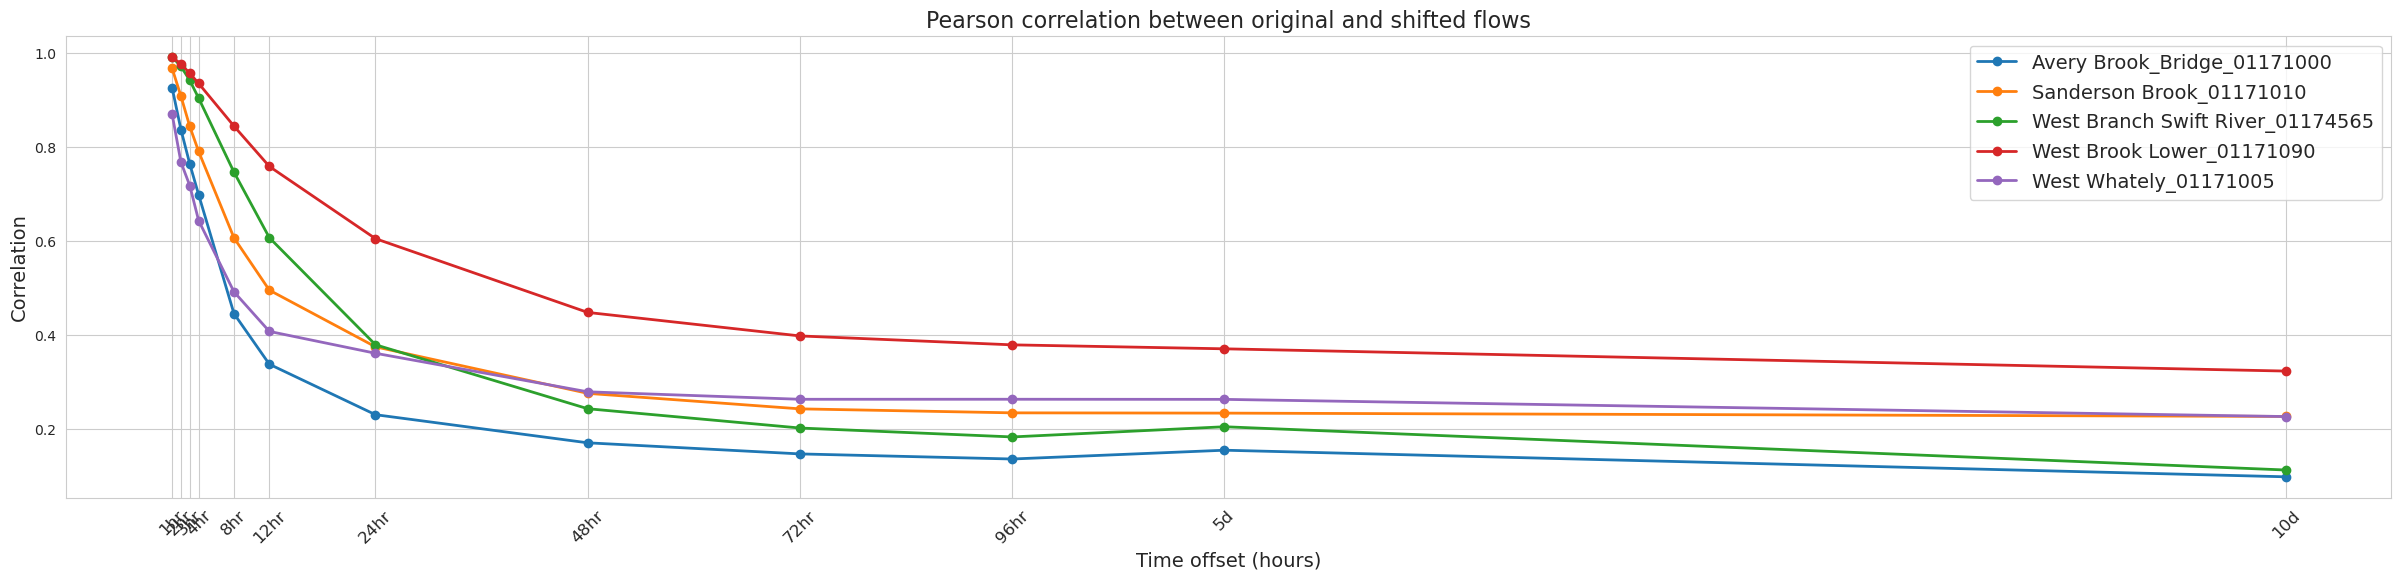

In [14]:
# Set the style of the plot
sns.set_style("whitegrid")

# Convert the time offsets to hours
time_offsets_hours = [1, 2, 3, 4, 8, 12, 24, 48, 72, 96, 5*24, 10*24]

# Plot the correlation values
fig, ax = plt.subplots(figsize=(30, 6))
for data_file, correlation_vals in correlation_values.items():
    ax.plot(time_offsets_hours, list(correlation_vals.values()), marker='o', linestyle='-', linewidth=2.0, label=data_file.split('/')[-3])
    ax.set_xlabel('Time offset (hours)', fontsize=14)
    ax.set_ylabel('Correlation', fontsize=14)

# Set the xticks to be proportional to the actual time offsets
ax.set_xticks(time_offsets_hours)
ax.set_xticklabels(correlation_values[data_files[0]].keys(), fontsize=12)

# Tilt the xticks for better readability
plt.xticks(rotation=45)

# Set the legend
ax.legend(fontsize=14)

# Set overall title
ax.set_title('Pearson correlation between original and shifted flows', fontsize=16)

plt.show()

2021-04-06 00:00:00+00:00 - 2021-08-24 00:00:00+00:00
2021-09-27 00:00:00+00:00 - 2022-01-04 00:00:00+00:00
2022-02-01 00:00:00+00:00 - 2022-04-30 00:00:00+00:00
2022-06-08 00:00:00+00:00 - 2023-06-07 00:00:00+00:00
793
365
364


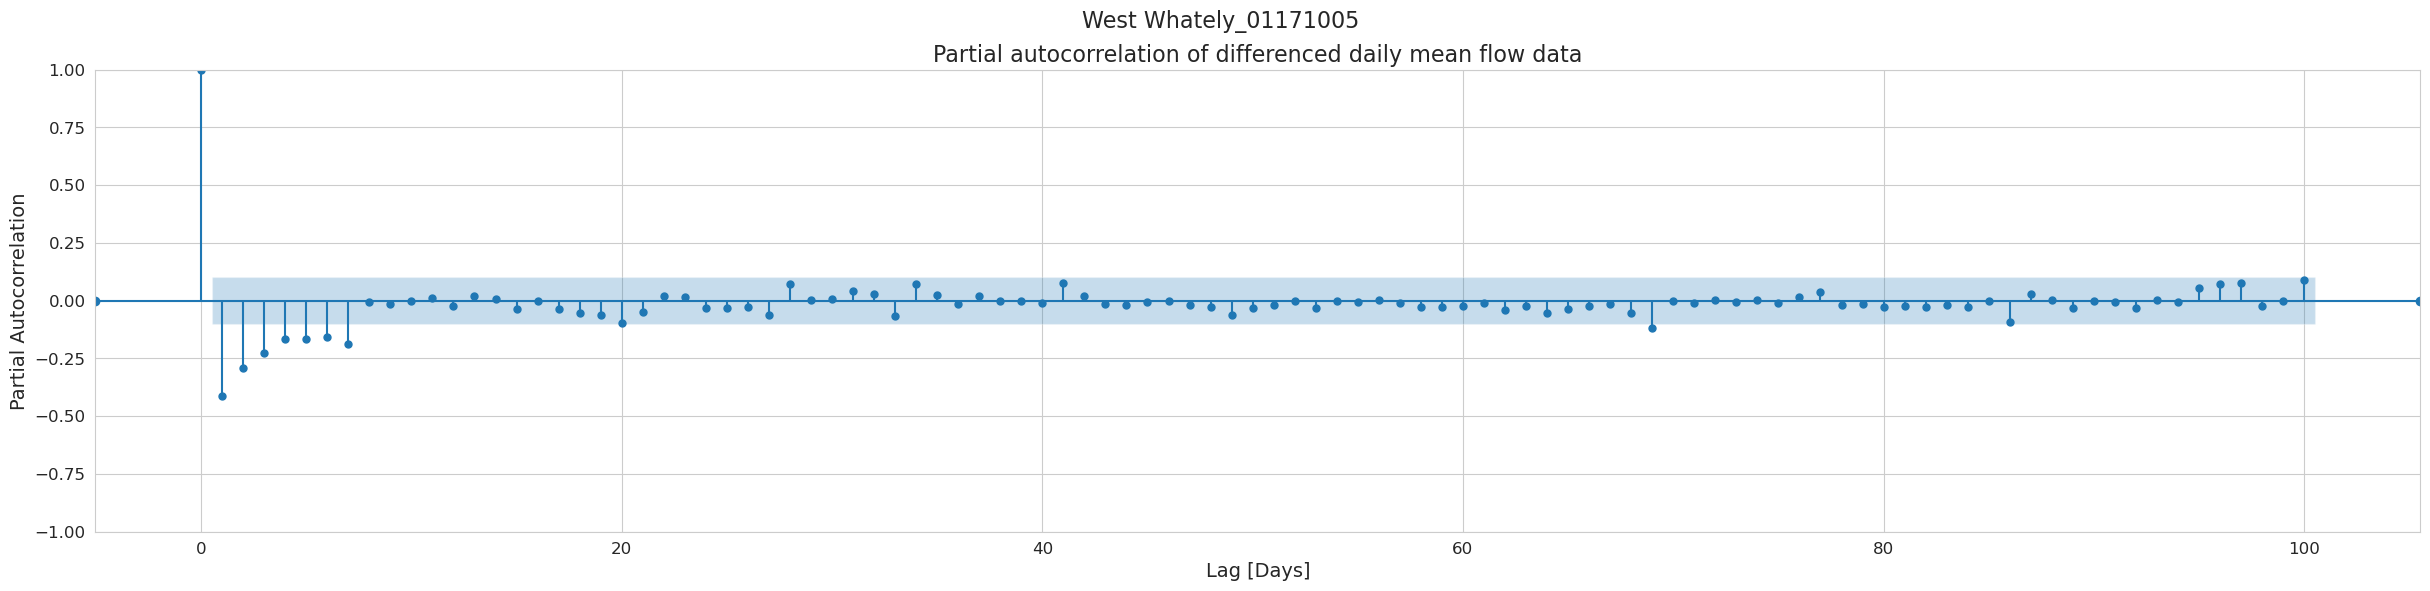

In [105]:
# Try to compute partial autocorrelation

# data does not have a constant frequency, resample to a constant frequency
site_idx = 4
data_file = data_files[site_idx]
data = pd.read_csv(data_file)
data['timestamp'] = pd.to_datetime(data['timestamp']) # convert to datetime
data = data.sort_values(by='timestamp')
data = data.dropna(subset=['value']) # drop rows with missing values
data = data[['timestamp', 'value']]
data.head(3)
resampled_data = data.resample('D', on='timestamp').mean()

# # plot the resampled data
# fig, ax = plt.subplots(figsize=(30, 6))
# ax.plot(resampled_data.index, resampled_data['value'], marker='o', linestyle='-', linewidth=2.0)
# ax.set_xlabel('Time', fontsize=14)
# ax.set_ylabel('Flow', fontsize=14)
# ax.set_title('Resampled flow data', fontsize=16)
# plt.show()

# get the start and end of time periods that have no NaNs
start = resampled_data.index[0]
end = resampled_data.index[0]
for i in range(1, len(resampled_data)):
    if pd.isna(resampled_data['value'].iloc[i]): # if the current value is NaN
        if not pd.isna(resampled_data['value'].iloc[i-1]): # if the previous value is not NaN
            end = resampled_data.index[i-1]
            print(f'{start} - {end}')
    else: # if the current value is not NaN
        if pd.isna(resampled_data['value'].iloc[i-1]): # if the previous value is NaN
            start = resampled_data.index[i]
# print the last non-NaN period
if not pd.isna(resampled_data['value'].iloc[-1]):
    end = resampled_data.index[-1]
    print(f'{start} - {end}')
longest_periods = [
    (pd.Timestamp("2023-03-06 00:00:00+00:00"), pd.Timestamp("2024-01-04 00:00:00+00:00")),
    (pd.Timestamp("2022-05-31 00:00:00+00:00"), pd.Timestamp("2023-03-02 00:00:00+00:00")),
    (pd.Timestamp("2017-09-14 00:00:00+00:00"), pd.Timestamp("2019-08-03 00:00:00+00:00")),
    (pd.Timestamp("2020-12-13 00:00:00+00:00"), pd.Timestamp("2022-04-30 00:00:00+00:00")),
    (pd.Timestamp("2022-06-08 00:00:00+00:00"), pd.Timestamp("2023-06-07 00:00:00+00:00"))
]

# filter the resampled data to only include the longest non-NaN period
print(len(resampled_data))
start, end = longest_periods[site_idx]
resampled_data = resampled_data[(resampled_data.index >= pd.Timestamp(start)) & (resampled_data.index <= pd.Timestamp(end))]
print(len(resampled_data))

# make it stationary by differencing
# resampled_data['diff'] = resampled_data['value'].diff()
resampled_data['diff'] = resampled_data['value'] # try without differencing
resampled_data = resampled_data.dropna()
print(len(resampled_data))

import seaborn as sns

# Set the style of the plot
sns.set_style("whitegrid")

# Compute and plot the partial autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(30, 6))
plot_pacf(resampled_data['diff'], ax=ax, lags=100, marker='o')

# Set the title and labels
ax.set_title('Partial autocorrelation of differenced daily mean flow data', fontsize=16)
fig.suptitle(data_file.split('/')[-3], fontsize=16)
ax.set_xlabel('Lag [Days]', fontsize=14)
ax.set_ylabel('Partial Autocorrelation', fontsize=14)

# Set the xticks and yticks
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.show()

